In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold, RandomizedSearchCV

In [13]:
df_large = pd.read_csv("large_preprocessed_week_24-05-2024.csv", low_memory=False)
df_large = df_large.drop(df_large.columns[0], axis=1)

In [14]:
df = df_large

In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
df.head()

,TRAFFIC_DATE,TRAINNUMBER,TRAINSERIE,TRAINSERIE_DIRECTION,STATION,ACTIVITYTYPE,DISTANCE_M,PLAN_DATETIME,REALIZED_DATETIME,DELAY,TURNOVER_INDICATOR,PREVIOUS_TRAINNUMBER,COMBINE,SPLIT,ROLLINGSTOCK_TYPE,NUMBER_CARRIAGES,DRIVER_CHANGE,DEPARTURE_SIGNAL_SHOWS_SAFE,CUM_DISTANCE_M,PLAN_TURNOVER_TIME,REALIZED_TURNOVER_TIME,MAX_DEPARTURE_TIME,PLAN_SIGNAL_SAFE_DELAY,REALIZED_SIGNAL_SAFE_DELAY,DALUREN,DAY_OF_WEEK,HOUR,DAY_OF_WEEK_sin,DAY_OF_WEEK_cos,HOUR_sin,HOUR_cos,NEEDED_PLAN_TURNOVER_TIME,NEEDED_REALIZED_TURNOVER_TIME,DIFF_TURNOVER_TIME,DIFF_TURNOVER_TIME_CAT
0,2023-01-01,11736,11700.0,E,Ut,V,0.0,2023-01-01 11:58:00+00:00,2023-01-01 11:59:02+00:00,62.0,1,NaN,0,0,DDZ,6.0,1,2023-01-01 11:57:07+00:00,24051.0,300.0,193.0,NaN,-53.0,-115.0,True,6,11,-0.781831,0.62349,2.588190e-01,-0.965926,298.0,191.0,107.0,too late
1,2023-01-01,11740,11700.0,E,Ut,V,0.0,2023-01-01 12:58:00+00:00,2023-01-01 12:57:59+00:00,-1.0,1,NaN,0,0,DDZ,6.0,1,2023-01-01 12:57:08+00:00,24051.0,300.0,279.0,NaN,-52.0,-51.0,True,6,12,-0.781831,0.62349,1.224647e-16,-1.000000,361.0,340.0,21.0,perfect
2,2023-01-01,11741,11700.0,O,Ut,V,0.0,2023-01-01 12:07:00+00:00,2023-01-01 12:07:25+00:00,25.0,1,NaN,0,0,DDZ,6.0,1,2023-01-01 12:06:07+00:00,60252.0,300.0,330.0,NaN,-53.0,-78.0,True,6,12,-0.781831,0.62349,1.224647e-16,-1.000000,335.0,365.0,-30.0,perfect
3,2023-01-01,11744,11700.0,E,Ut,V,0.0,2023-01-01 13:58:00+00:00,2023-01-01 13:58:09+00:00,9.0,1,NaN,0,0,ICM,6.0,1,2023-01-01 13:57:07+00:00,24051.0,300.0,223.0,NaN,-53.0,-62.0,True,6,13,-0.781831,0.62349,-2.588190e-01,-0.965926,351.0,274.0,77.0,too late
4,2023-01-01,11745,11700.0,O,Ut,V,0.0,2023-01-01 13:07:00+00:00,2023-01-01 13:07:20+00:00,20.0,1,NaN,0,0,ICM,6.0,1,2023-01-01 13:06:07+00:00,60252.0,300.0,349.0,NaN,-53.0,-73.0,True,6,13,-0.781831,0.62349,-2.588190e-01,-0.965926,340.0,389.0,-49.0,perfect


In [16]:
df = df[df['NUMBER_CARRIAGES'].notna()]
df["NUMBER_CARRIAGES"] = df["NUMBER_CARRIAGES"].astype(int)

C:\Users\Tim Rentenaar\AppData\Local\Temp\ipykernel_15716\368654501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["NUMBER_CARRIAGES"] = df["NUMBER_CARRIAGES"].astype(int)


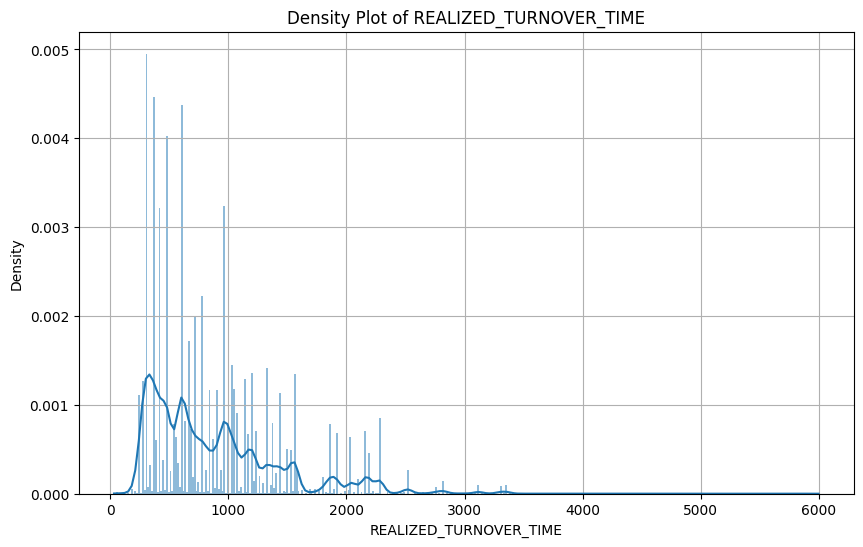

In [17]:
# Creating the density plot
plt.figure(figsize=(10, 6))
sns.histplot(df["PLAN_TURNOVER_TIME"], kde=True, stat="density", linewidth=0)
plt.title('Density Plot of REALIZED_TURNOVER_TIME')
plt.xlabel('REALIZED_TURNOVER_TIME')
plt.ylabel('Density')
plt.grid(True)
plt.show()

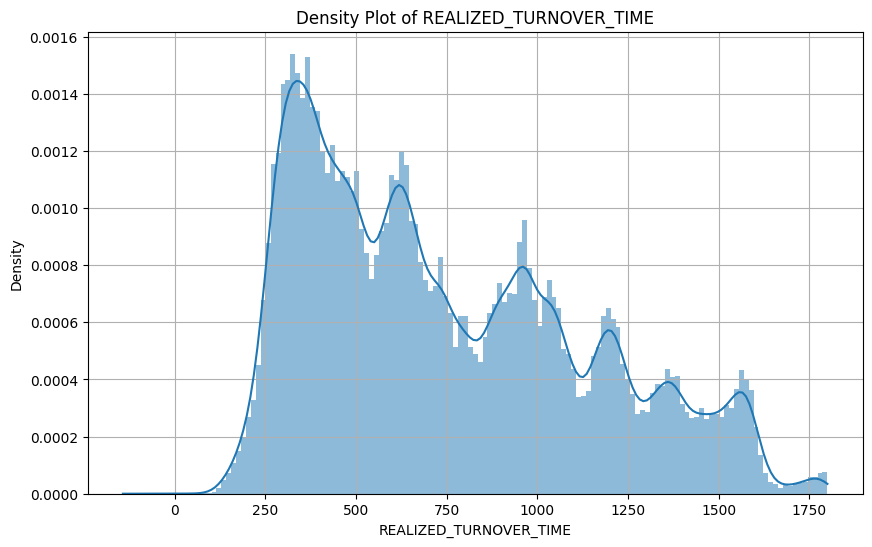

In [18]:
df = df[df["DELAY"] <= 180]
df = df[df["REALIZED_TURNOVER_TIME"] <= 1800]

# Creating the density plot
plt.figure(figsize=(10, 6))
sns.histplot(df["REALIZED_TURNOVER_TIME"], kde=True, stat="density", linewidth=0)
plt.title('Density Plot of REALIZED_TURNOVER_TIME')
plt.xlabel('REALIZED_TURNOVER_TIME')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [19]:
# Prepare the features and target variable
features = df[["REALIZED_TURNOVER_TIME", "NEEDED_REALIZED_TURNOVER_TIME", "STATION", "ROLLINGSTOCK_TYPE", "NUMBER_CARRIAGES","DRIVER_CHANGE","DAY_OF_WEEK_sin","DAY_OF_WEEK_cos","HOUR_sin","HOUR_cos"]]
features["NEEDED_REALIZED_TURNOVER_TIME"] = features["NEEDED_REALIZED_TURNOVER_TIME"] - 60
features = features.dropna()

y = features["REALIZED_TURNOVER_TIME"]
X = features.drop(columns=["REALIZED_TURNOVER_TIME", "NEEDED_REALIZED_TURNOVER_TIME"])
X = pd.get_dummies(X, columns=['STATION', 'ROLLINGSTOCK_TYPE'], drop_first=False)

C:\Users\Tim Rentenaar\AppData\Local\Temp\ipykernel_15716\642055494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["NEEDED_REALIZED_TURNOVER_TIME"] = features["NEEDED_REALIZED_TURNOVER_TIME"] - 60


In [20]:
# Define the parameter grid for hyperparameter search
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [21]:
# Define the model
rf = RandomForestRegressor(random_state=42)

In [22]:
# Perform randomized search with cross-validation

# Start the timer
start_time = time.time()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=50, cv=kf, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X, y)

# End the timer
end_time = time.time()

In [23]:
# Calculate the elapsed time
elapsed_time = end_time - start_time
elapsed_hours = elapsed_time // 3600
elapsed_minutes = (elapsed_time % 3600) // 60
elapsed_seconds = elapsed_time % 60

print(f"Training completed in {elapsed_hours:.0f} hours, {elapsed_minutes:.0f} minutes, and {elapsed_seconds:.2f} seconds.")

Training completed in 23 hours, 25 minutes, and 38.08 seconds.


In [24]:
# Get the best estimator
rf_best = random_search.best_estimator_

In [25]:
# Compute cross-validated predictions to calculate residuals
y_pred_cv = cross_val_predict(rf_best, X, y, cv=kf)
cv_residuals = y - y_pred_cv
y_pred_80 = y_pred_cv + cv_residuals.quantile(0.8)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss

mae = mean_absolute_error(y, y_pred_cv)
mse = mean_squared_error(y, y_pred_cv)
r2 = r2_score(y, y_pred_cv)
pbloss = mean_pinball_loss(y, y_pred_80, alpha=0.8)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Pinball loss:", pbloss)

Mean Absolute Error: 116.98517853645043
Mean Squared Error: 38538.89691462015
R-squared: 0.7393556070776539
Pinball loss: 48.5784590694252


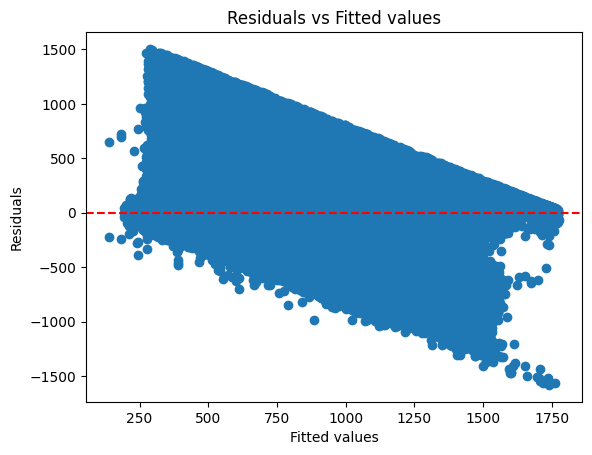

In [27]:
# Plot residuals vs. fitted values
plt.scatter(y_pred_cv, cv_residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [28]:
# Fit the best model on the entire dataset
rf_best.fit(X, y)
train_residuals = y - rf_best.predict(X)

In [29]:
# Save the best model and residuals
joblib_file = "rf_realized_best.pkl"
joblib.dump(rf_best, joblib_file)
np.save("rf_realized_best_train_residuals.npy", train_residuals)

In [30]:
print("Best model and residuals saved successfully.")
print("Best parameters found: ", random_search.best_params_)

Best model and residuals saved successfully.
Best parameters found:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


In [31]:
# Convert the results to a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Sort by the best score
results = results.sort_values(by='rank_test_score')

# Display the top results
print(results.head(10))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_n_estimators param_min_samples_split param_min_samples_leaf param_max_features param_max_depth                                             params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
37     360.477670      7.793369        14.399233        0.573899                100                      10                      1               sqrt            None  {'n_estimators': 100, 'min_samples_split': 10,...      -38860.601561      -38661.909229      -38399.924491      -38436.696899      -38335.352394    -38538.896915      194.840683                1
18    4072.479253     21.554150        29.775172        2.017880                200                      10                      4               None            None  {'n_estimators': 200, 'min_samples_split': 10,...      -38906.410163      -38778.546678      -38307.954403   

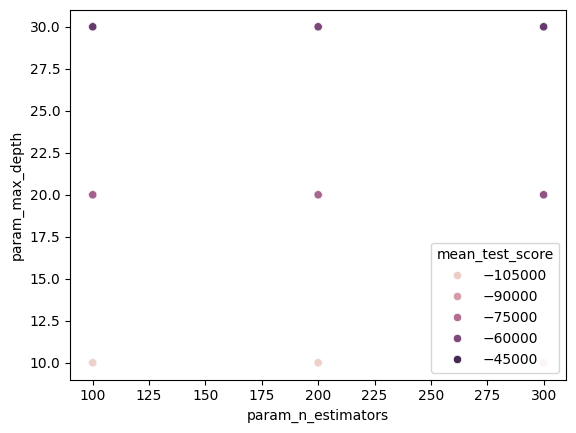

In [32]:
# Scatter plot of n_estimators vs. max_depth
sns.scatterplot(x=results['param_n_estimators'], y=results['param_max_depth'], hue=results['mean_test_score'])
plt.show()

In [1]:
# Scatter plot of n_estimators vs. max_depth
sns.scatterplot(x=results['param_min_samples_split'], y=results['param_min_samples_leaf'], hue=results['mean_test_score'])
plt.show()

NameError: name 'sns' is not defined